In [1]:
# Figure 3  R plot figures

In [ ]:
# BiocManager::install('ggpubr')
# BiocManager::install('ggsignif')
# BiocManager::install('igraph')

In [1]:
library(igraph)
library(Seurat)
library(ggsci)
library(scales)
library(ggplot2)
library(dplyr)
library(viridis)
library(tidyverse)
library(reshape2)
library(stringr)
library(ggsignif)

#A few self-defined functions
source("./common_amplicon_statistics.r")
library(ggrepel)
library(ggpubr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Attaching SeuratObject

‘SeuratObject’ was built under R 4.2.0 but the current version is
4.2.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode


Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal


── Attaching core tidyverse packages ───────────

In [2]:
#select four colors for different samples
colors = pal_npg(palette = c("nrc"), alpha = 1)(6)
colors

[1] "#E64B35FF" "#4DBBD5FF" "#00A087FF" "#3C5488FF" "#F39B7FFF" "#8491B4FF"

In [3]:
scheme = pal_aaas(palette = c("default"), alpha = 1)(4)
#options(repr.plot.width=6, repr.plot.height=6)
#show_col(scheme)

# cell type annotation

In [4]:
EB.combined = readRDS('../data/EBcombined.rds')

In [5]:
cell_type = c('Heart','Neuron', 'Gut','Blood', 'CPM','PGC-like','Endothelium')
colors = c('#1F77B4FF','#FF7F0EFF','#2CA02CFF','#D62728FF','#9467BDFF','#8C564BFF','#E377C2FF')
cl_cols = setNames(colors, cell_type)

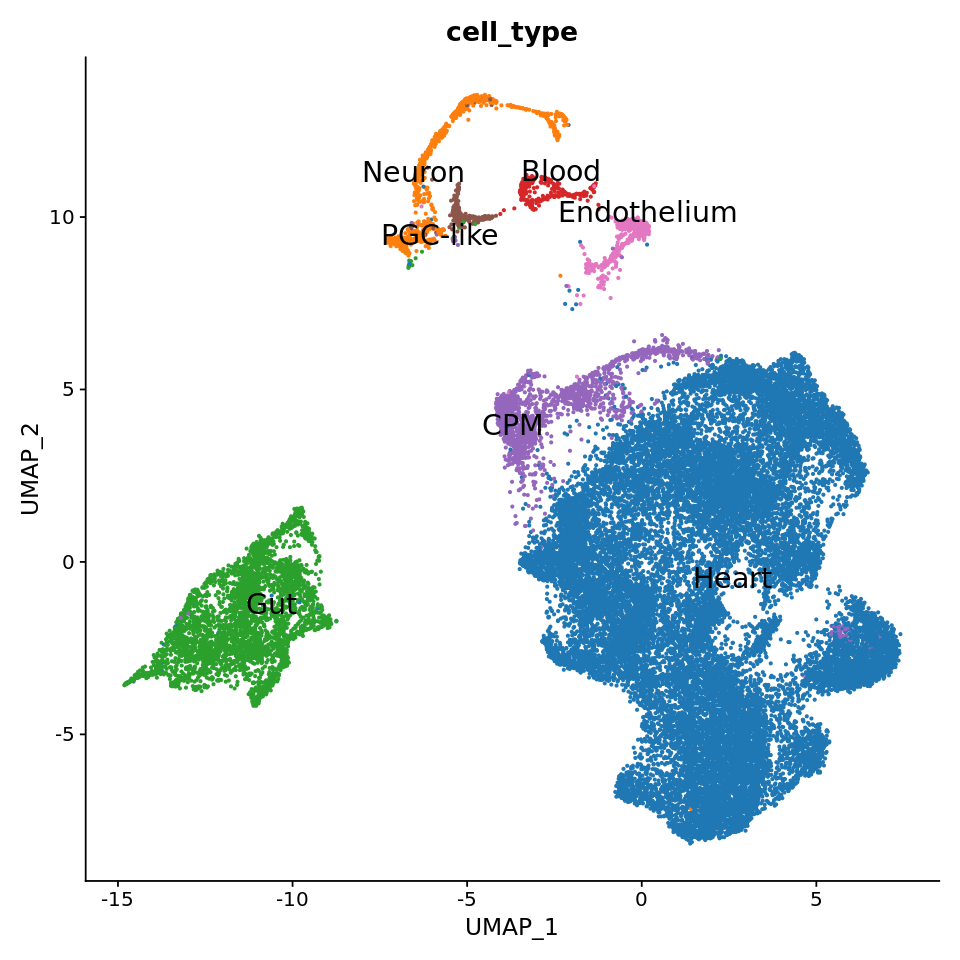

In [7]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(EB.combined, reduction = 'umap', group.by = 'cell_type', cols = cl_cols, label = TRUE, repel=TRUE, , pt.size = 0.5, label.size=6) + NoLegend()
ggsave("../results/Fig3_celltype_annotation.pdf", width=8, height=8)

# load EBsc_amplicon data and preprocess

In [8]:
#load amplicon umi_table datasets preprocessed by Zhumiao
input_dir = '../data/EBsc_amplicon/'
EB6 = read.csv(paste0(input_dir,'D8a_molecule_table.csv'), row.names=1)
EB7 = read.csv(paste0(input_dir,'D10a_molecule_table.csv'), row.names=1)

EBd8 = read.csv(paste0(input_dir,'D8b_molecule_table.csv'), row.names=1)
EBd10 = read.csv(paste0(input_dir,'D10b_molecule_table.csv'), row.names=1)
EBd12 = read.csv(paste0(input_dir,'D12_molecule_table.csv'), row.names=1)
EBd14 = read.csv(paste0(input_dir,'D14_molecule_table.csv'), row.names=1)

In [9]:
#merge all datasets, avoid cell name conficts in different  datasets 
EB6$cellBC = paste0(EB6$cellBC, "_1")
EB7$cellBC = paste0(EB7$cellBC, "_2")

EBd8$cellBC = paste0(EBd8$cellBC, "_3")
EBd10$cellBC = paste0(EBd10$cellBC, "_4")
EBd12$cellBC = paste0(EBd12$cellBC, "_5")
EBd14$cellBC = paste0(EBd14$cellBC, "_6")


EB6$sample = "D8a"
EB7$sample = "D10a"

EBd8$sample = "D8b"
EBd10$sample = "D10b"
EBd12$sample = "D12"
EBd14$sample = "D14"

#checking the barcode diversity at allele level and cell level

In [85]:
scar_merge = function(x) {
    indel = ""
    for (i in x) {
        indel  = paste(indel, i, sep="|")
    }
    return(indel)
}

In [10]:
#merge datasets
EB_target = rbind(EB6, EB7, EBd8, EBd10, EBd12, EBd14) %>% dplyr::select(readName, intBC,r1, r2, r3, r4, sample)

In [11]:
#preprocess step,remove unnecessary strings
EB_target$r1 = gsub("[ATCG]" , "", EB_target$r1)
EB_target$r2 = gsub("[ATCG]" , "", EB_target$r2)
EB_target$r3 = gsub("[ATCG]" , "", EB_target$r3)
EB_target$r4 = gsub("[ATCG]" , "", EB_target$r4)

#check the shannon diversity between Cas9 and Cpf1 indels in different samples
EB_target$cpf1 = paste(EB_target$r1, EB_target$r2, sep="|")
EB_target$cas9 = paste(EB_target$r3, EB_target$r4, sep="|")

#r1r3 just for comparison
EB_target$r1r3 = paste(EB_target$r1, EB_target$r3, sep="|")
EB_target$r2r4 = paste(EB_target$r2, EB_target$r4, sep="|")
EB_target$r1r4 = paste(EB_target$r1, EB_target$r4, sep="|")
EB_target$r2r3 = paste(EB_target$r2, EB_target$r3, sep="|")

EB_target$all = paste(EB_target$r1, EB_target$r2, EB_target$r3, EB_target$r4, sep="|")

EB_target$combine= paste0(EB_target$intBC, EB_target$all)

## Fig 3D-F barcode entropy and mutation fraction

In [12]:
#check the shannon index of all targets for each sample, using split do.call function instead of group_by function 
EB_target_split = split(EB_target, list(EB_target$sample))
EB_target_shannon = do.call(rbind, lapply(EB_target_split, function(target) {
    shannon_table = data.frame(r1=double(), r2=double(), r3=double(), r4=double(), 
                               cpf1=double(), cas9=double(), r1r3=double(), r2r4=double(), r1r4=double(),r2r3=double(),
                               all=double(), intBC=double(), combine=double())
   
    r1_target = as.data.frame(table(target$r1))
    r2_target = as.data.frame(table(target$r2))
    r3_target = as.data.frame(table(target$r3))
    r4_target = as.data.frame(table(target$r4))
    r1v = round(shannon(r1_target$Freq), 2)
    r2v = round(shannon(r2_target$Freq), 2)
    r3v = round(shannon(r3_target$Freq), 2)
    r4v = round(shannon(r4_target$Freq), 2)
    
    cpf1_target = as.data.frame(table(target$cpf1))
    cas9_target = as.data.frame(table(target$cas9))
    cpf1v = round(shannon(cpf1_target$Freq), 2)
    cas9v = round(shannon(cas9_target$Freq), 2)
    
    r1r3_target = as.data.frame(table(target$r1r3))
    r2r4_target = as.data.frame(table(target$r2r4))
    r1r4_target = as.data.frame(table(target$r1r4))
    r2r3_target = as.data.frame(table(target$r2r3))
    r1r3v = round(shannon(r1r3_target$Freq), 2)
    r2r4v = round(shannon(r2r4_target$Freq), 2)
    r1r4v = round(shannon(r1r4_target$Freq), 2)
    r2r3v = round(shannon(r2r3_target$Freq), 2)

    all_target = as.data.frame(table(target$all))
    allv = round(shannon(all_target$Freq), 2)
    
    intBCs = as.data.frame(table(target$intBC))
    intBCv = round(shannon(intBCs$Freq), 2)
    
    combines = as.data.frame(table(target$combine))
    combinev = round(shannon(combines$Freq), 2)
    
    shannon_table[1, ] = c(r1v, r2v, r3v, r4v, cpf1v, cas9v, r1r3v, r2r4v, r1r4v, r2r3v, allv, intBCv, combinev)
    return(shannon_table)
}))

In [13]:
EB_target_shannon

,r1,r2,r3,r4,cpf1,cas9,r1r3,r2r4,r1r4,r2r3,all,intBC,combine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D10a,1.81,3.13,2.51,1.03,4.03,3.22,3.89,3.83,2.67,4.81,5.82,7.86,9.03
D10b,0.95,1.13,0.96,0.21,1.67,1.13,1.77,1.31,1.14,1.85,2.47,6.55,7.03
D12,0.63,0.84,0.61,0.22,1.29,0.78,1.15,0.98,0.82,1.29,1.79,6.08,6.35
D14,0.24,0.74,0.82,0.13,0.91,0.89,0.98,0.85,0.35,1.26,1.45,6.23,6.41
D8a,1.84,3.51,2.26,1.11,4.28,2.97,3.66,4.20,2.72,4.87,5.79,7.09,8.22
D8b,0.85,1.14,1.34,0.53,1.84,1.70,1.94,1.50,1.33,1.99,2.83,7.84,8.24


In [14]:
# barcode entropy of mutated barcodes less than theorectical value? sampling issues? or current calcualtion does not remove the non-linear values?
EBall_mut_rate = EB_target %>% select(sample, r1, r2, r3, r4, cas9, cpf1, all) %>% group_by(sample) %>% 
    summarise(ratio = length(grep('[ID]', all))/length(all),
              r1ratio = length(grep('[ID]', r1))/length(r1),
              r2ratio = length(grep('[ID]', r2))/length(r2),
              r3ratio = length(grep('[ID]', r3))/length(r3),
              r4ratio = length(grep('[ID]', r4))/length(r4),
              cas9ratio = length(grep('[ID]', cas9))/length(cas9),
              cpf1ratio = length(grep('[ID]', cpf1))/length(cpf1)
             )
EBall_mut_rate

sample,ratio,r1ratio,r2ratio,r3ratio,r4ratio,cas9ratio,cpf1ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D10a,0.5734389,0.19334506,0.34942832,0.34936969,0.08132512,0.37443565,0.41893873
D10b,0.2765058,0.11269408,0.13119417,0.13387028,0.01928870,0.15041822,0.18472935
D12,0.1924347,0.06921137,0.09759285,0.06795048,0.01994498,0.08452545,0.14536910
D14,0.1589592,0.02140975,0.08017128,0.10606061,0.01086957,0.11198946,0.09624506
D8a,0.6446998,0.21634687,0.43491343,0.35756918,0.10708825,0.39091402,0.48813693
D8b,0.2871502,0.08673802,0.11666001,0.15846248,0.04392624,0.18720693,0.19258994


In [15]:
EBall_mut_rate$diversity = EB_target_shannon$all
EBall_mut_rate$r1div = EB_target_shannon$r1
EBall_mut_rate$r2div = EB_target_shannon$r2
EBall_mut_rate$r3div = EB_target_shannon$r3
EBall_mut_rate$r4div = EB_target_shannon$r4
EBall_mut_rate$cas9div = EB_target_shannon$cas9
EBall_mut_rate$cpf1div = EB_target_shannon$cpf1

EBall_mut_rate$sample = factor(EBall_mut_rate$sample, levels=c('D8a', 'D10a', 'D8b', 'D10b', 'D12', 'D14'))
EBall_mut_rate

sample,ratio,r1ratio,r2ratio,r3ratio,r4ratio,cas9ratio,cpf1ratio,diversity,r1div,r2div,r3div,r4div,cas9div,cpf1div
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D10a,0.5734389,0.19334506,0.34942832,0.34936969,0.08132512,0.37443565,0.41893873,5.82,1.81,3.13,2.51,1.03,3.22,4.03
D10b,0.2765058,0.11269408,0.13119417,0.13387028,0.01928870,0.15041822,0.18472935,2.47,0.95,1.13,0.96,0.21,1.13,1.67
D12,0.1924347,0.06921137,0.09759285,0.06795048,0.01994498,0.08452545,0.14536910,1.79,0.63,0.84,0.61,0.22,0.78,1.29
D14,0.1589592,0.02140975,0.08017128,0.10606061,0.01086957,0.11198946,0.09624506,1.45,0.24,0.74,0.82,0.13,0.89,0.91
D8a,0.6446998,0.21634687,0.43491343,0.35756918,0.10708825,0.39091402,0.48813693,5.79,1.84,3.51,2.26,1.11,2.97,4.28
D8b,0.2871502,0.08673802,0.11666001,0.15846248,0.04392624,0.18720693,0.19258994,2.83,0.85,1.14,1.34,0.53,1.70,1.84


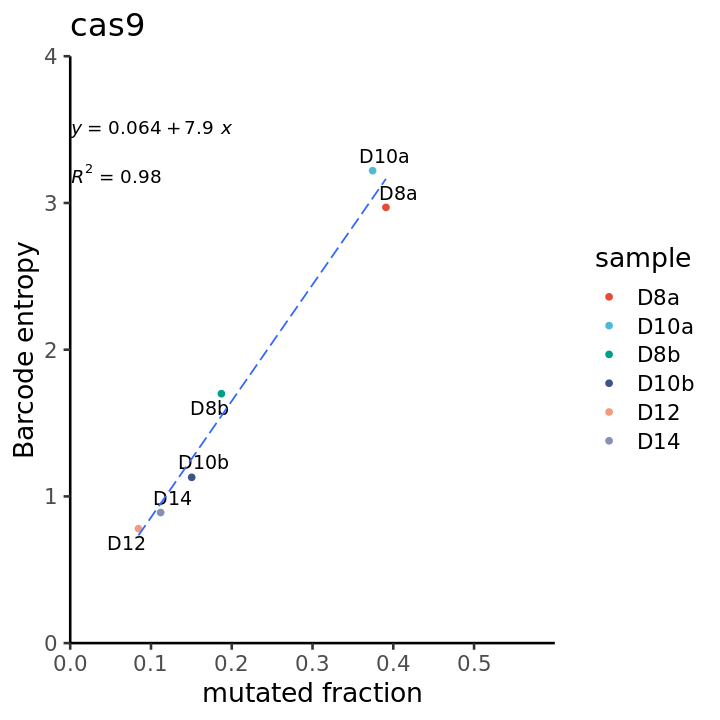

In [16]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(EBall_mut_rate, aes(x=cas9ratio, y=cas9div))+geom_point(aes(fill=sample, color=sample))+
    geom_text_repel(aes(label=sample), size=4)+
    #theme(axis.text = element_text(size=16, color="black"))+
    scale_fill_npg()+
    labs(x='mutated fraction',y='Barcode entropy')+scale_y_continuous(expand=c(0,0), limits=c(0,4))+
    scale_x_continuous(expand=c(0,0), limits=c(0, 0.6))+
    geom_smooth(formula = 'y ~ x', method='lm', se=FALSE, linetype='longdash', linewidth=0.5)+
    # annotate('text', x=0.1, y=5.5, label = paste0('r = ', round(pearson_cor, 2)))
    stat_regline_equation(label.y=3.5, aes(label=after_stat(eq.label)))+
    stat_regline_equation(label.y=3.2, aes(label=after_stat(rr.label)))+
    ggtitle('cas9')+
    theme_classic(base_size = 16)+scale_color_npg()
ggsave('../results/Fig3_mouseEB_mutated_fraction_cas9_diversity.pdf', width=6, height=6)

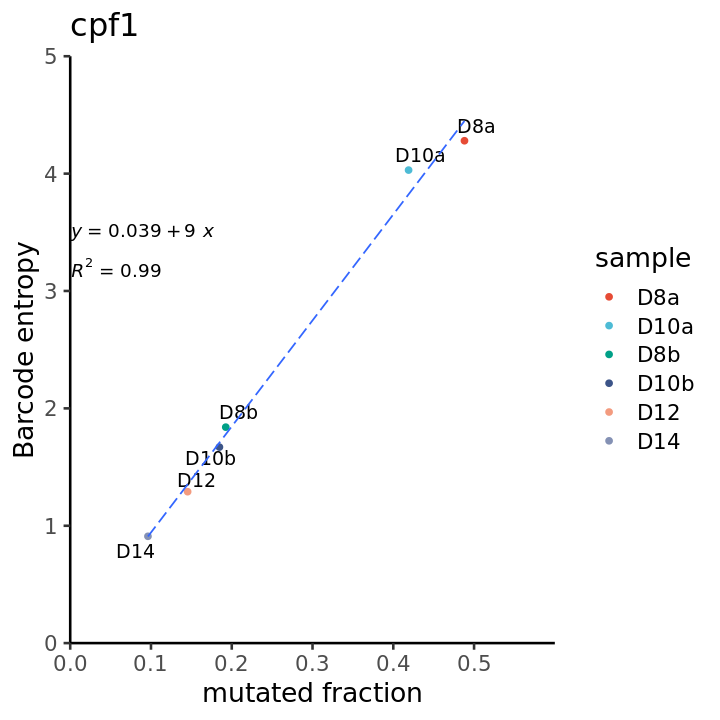

In [17]:
options(repr.plot.width=6, repr.plot.height=6)
ggplot(EBall_mut_rate, aes(x=cpf1ratio, y=cpf1div))+geom_point(aes(fill=sample, color=sample))+
    geom_text_repel(aes(label=sample), size=4)+
    #theme(axis.text = element_text(size=16, color="black"))+
    scale_fill_npg()+
    labs(x='mutated fraction',y='Barcode entropy')+scale_y_continuous(expand=c(0,0), limits=c(0,5))+
    scale_x_continuous(expand=c(0,0), limits=c(0, 0.6))+
    geom_smooth(formula = 'y ~ x', method='lm', se=FALSE, linetype='longdash', linewidth=0.5)+
    # annotate('text', x=0.1, y=5.5, label = paste0('r = ', round(pearson_cor, 2)))
    stat_regline_equation(label.y=3.5, aes(label=after_stat(eq.label)))+
    stat_regline_equation(label.y=3.2, aes(label=after_stat(rr.label)))+
    ggtitle('cpf1')+
    theme_classic(base_size = 16)+scale_color_npg()
ggsave('../results/Fig3_mouseEB_mutated_fraction_cpf1_diversity.pdf', width=6, height=6)

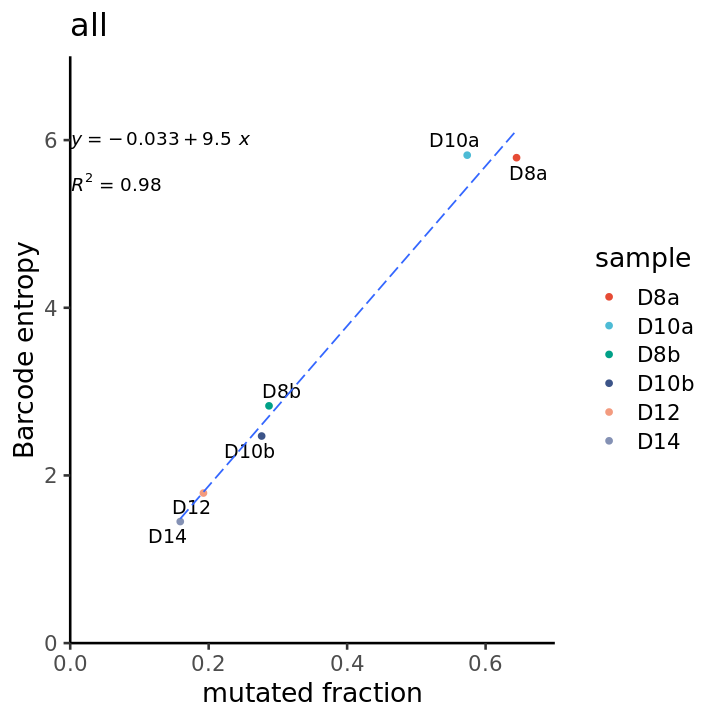

In [18]:
# pearson_cor = cor(EBall_mut_rate$ratio, EBall_mut_rate$diversity, method='pearson')

options(repr.plot.width=6, repr.plot.height=6)
ggplot(EBall_mut_rate, aes(x=ratio, y=diversity))+geom_point(aes(fill=sample, color=sample))+
    geom_text_repel(aes(label=sample), size=4)+
    #theme(axis.text = element_text(size=16, color="black"))+
    scale_fill_npg()+
    labs(x='mutated fraction',y='Barcode entropy')+scale_y_continuous(expand=c(0,0), limits=c(0,7))+
    scale_x_continuous(expand=c(0,0), limits=c(0, 0.7))+
    geom_smooth(formula = 'y ~ x', method='lm', se=FALSE, linetype='longdash', linewidth=0.5)+
    # annotate('text', x=0.1, y=5.5, label = paste0('r = ', round(pearson_cor, 2)))
    stat_regline_equation(label.y=6, aes(label=after_stat(eq.label)))+
    stat_regline_equation(label.y=5.5, aes(label=after_stat(rr.label)))+
    ggtitle('all')+
    theme_classic(base_size = 16)+scale_color_npg()
ggsave('../results/Fig3_mouseEB_mutated_fraction_diversity.pdf', width=6, height=6)

# Figure 3C

In [19]:
#check the target shannon index for each sample, using split do.call function instead of group_by function 
EB_target_split = split(EB_target, list(EB_target$sample))
EB_target_shannon = do.call(rbind, lapply(EB_target_split, function(target) {
    shannon_table = data.frame(cpf1_index=double(), cas9_index=double())
    cpf1_target = as.data.frame(table(target$cpf1))
    cas9_target = as.data.frame(table(target$cas9))
    cpf1 = round(shannon(cpf1_target$Freq), 2)
    cas9 = round(shannon(cas9_target$Freq), 2)
    shannon_table[1, ] = c(cpf1, cas9)
    return(shannon_table)
}))
EB_target_shannon$sample = rownames(EB_target_shannon)
EB_target_shannon = EB_target_shannon %>% pivot_longer(cols=c('cpf1_index', 'cas9_index'), names_to = 'target', values_to='index')
EB_target_shannon$sample = factor(factor(EB_target_shannon$sample), levels=c('D8a', 'D10a','D8b',  'D10b', 'D12', 'D14'))


In [23]:
#paired wilcox.test and t.test
#save the target shannon
EB_cas9cpf1_shan = EB_target_shannon
head(EB_target_shannon)
cpf1 = EB_cas9cpf1_shan$index[seq(1, nrow(EB_cas9cpf1_shan), by=2)]
cas9 = EB_cas9cpf1_shan$index[seq(2, nrow(EB_cas9cpf1_shan), by=2)]
wilcox.test(cpf1, cas9, paired=TRUE)
t.test(cpf1, cas9, paired=TRUE)

sample,target,index
<fct>,<chr>,<dbl>
D10a,cpf1_index,4.03
D10a,cas9_index,3.22
D10b,cpf1_index,1.67
D10b,cas9_index,1.13
D12,cpf1_index,1.29
D12,cas9_index,0.78



	Wilcoxon signed rank exact test

data:  cpf1 and cas9
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0



	Paired t-test

data:  cpf1 and cas9
t = 2.904, df = 5, p-value = 0.03363
alternative hypothesis: true mean difference is not equal to 0
95 percent confidence interval:
 0.06372287 1.04627713
sample estimates:
mean difference 
          0.555 


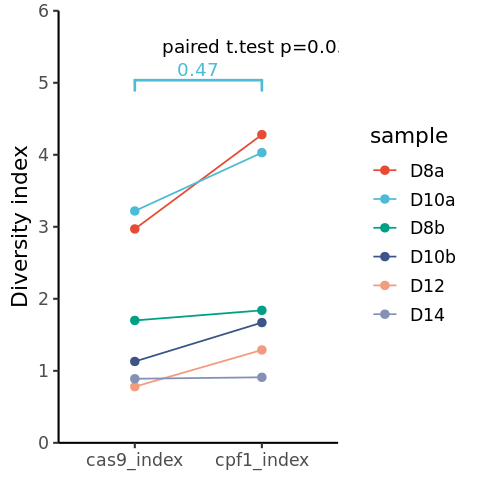

In [24]:
#plot the shannon index difference, should use pair t-test statistics
#paired t-test required to check whether the dataset is fit to normal distribution
#pair wilcox.test does not require such check
options(repr.plot.width=4, repr.plot.height=4)
compaired = list(c("cpf1_index","cas9_index"))
ggplot(EB_target_shannon, aes(x=target,y=index, group=sample, color=sample))+
    #geom_jitter(aes(color=sample,fill=sample), width=0.1)+
    #geom_point(aes(color=sample,fill=sample), size=1)+
    geom_point(size=2)+
    geom_line("stat"="identity", size=0.5)+
    theme_classic(base_size = 13)+scale_color_npg()+scale_fill_npg()+
    geom_signif(comparisons = compaired, size=0.75, y_position = c(4.8), test = 't.test')+
    labs(x=NULL,y='Diversity index')+scale_y_continuous(expand=c(0,0), limits=c(0,6))+
    annotate("text", x='cpf1_index', y=5.5, label="paired t.test p=0.033")
ggsave("../results/Fig3_cpf1_cas9_target_shannon_index.pdf", width=6, height=6)